## Part A: Installing yfinance

In [1]:
!pip install yfinance

## Part B: Import libraries, download data, and ready the environment

In [2]:
import yfinance as yf
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd

from sklearn.preprocessing import MinMaxScaler

import torch
import torch.nn as nn

from torch.utils.data import DataLoader, Dataset

In [3]:
# Define the ticker symbol
ticker = yf.Ticker("BTC-USD")

# Download the historical data
train_data = ticker.history(start="2019-01-01", end="2024-01-01")
test_data = ticker.history(start="2024-01-01")

In [4]:
train_data_open = train_data['Open']
test_data_open = test_data['Open']

In [5]:
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
device

'cuda:0'

## Part C: Plot the data

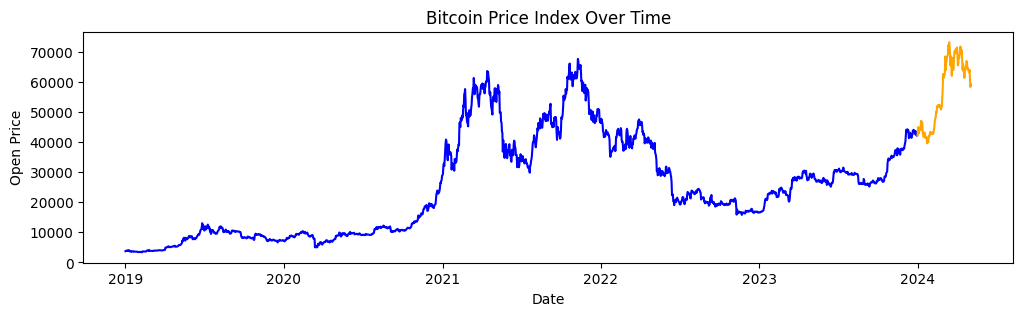

In [6]:
# Create a figure and axis
fig, ax = plt.subplots()

# Set the width and height of figure
fig.set_figwidth(12)
fig.set_figheight(3)

# Plot the training data in blue
ax.plot(train_data.index, train_data_open, color='blue')

# Plot the test data in orange
ax.plot(test_data.index, test_data_open, color='orange')

# Set the title and labels
ax.set_title('Bitcoin Price Index Over Time')
ax.set_xlabel('Date')
ax.set_ylabel('Open Price')

# Display the plot
plt.show()

## Part D: Normalize the Open Price values

In [7]:
# Create a MinMaxScalar Object
min_max_scaler = MinMaxScaler(feature_range=(-1, 1))

# Fit on train_data and tranform it
train_data_open = min_max_scaler.fit_transform(train_data_open.values.reshape(-1, 1))

# Transform test data
test_data_open = min_max_scaler.transform(test_data_open.values.reshape(-1, 1))

In [8]:
# See Changes
print('Train data after scaling. min:', train_data_open.min(), '... max:', train_data_open.max())

Train data after scaling. min: -1.0 ... max: 1.0000000000000002


## Part E: Generate the train and test data with correct format

In [9]:
def create_dataset(data, look_back):
    #Declare X and y as empty list
    X = []
    y = []

    for i in range(len(data)):
        #get the last index
        lastIndex = i + look_back

        #if lastIndex is greater than length of sequence then break
        if lastIndex > len(data) - 1:
            break

        #append data_X, data_y in X and y list
        X.append(data[i:lastIndex])
        y.append(data[lastIndex])

    #Convert X and y into numpy array and return them
    return np.array(X), np.array(y)

In [10]:
n = 60
trainX, trainY = create_dataset(train_data_open, n)
testX, testY = create_dataset(test_data_open, n)

In [11]:
print('shape of train data X and Y:', trainX.shape, trainY.shape)
print('shape of test data X and Y:', testX.shape, testY.shape)

shape of train data X and Y: (1766, 60, 1) (1766, 1)
shape of test data X and Y: (64, 60, 1) (64, 1)


In [12]:
# Convert datasets to torch.tensor data type
def convert_numpy_to_tensor(dataset):
    return torch.tensor(dataset).float()

trainX = convert_numpy_to_tensor(trainX)
trainY = convert_numpy_to_tensor(trainY)
testX = convert_numpy_to_tensor(testX)
testY = convert_numpy_to_tensor(testY)

In [13]:
class StockDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __len__(self):
        return len(self.X)

    def __getitem__(self, i):
        return self.X[i], self.y[i]

train_dataset = StockDataset(trainX, trainY)
test_dataset = StockDataset(testX, testY)

## Part F: Create model

In [14]:
class BTC_LSTM_Model(nn.Module):
    def __init__(self, input_size, hidden_size, num_stacked_layers, dropout, batch_first):
        super().__init__()

        self.hidden_size = hidden_size
        self.num_stacked_layers = num_stacked_layers

        # batch_first=True -> input and output tensors are provided as (batch, seq, feature) instead of (seq, batch, feature)
        self.lstm = nn.LSTM(
            input_size=input_size,
            hidden_size=hidden_size,
            num_layers=num_stacked_layers,
            dropout=dropout,
            batch_first=batch_first
        )
        self.linear = nn.Linear(hidden_size, 1)

    def forward(self, X):
        # Initialize h0 and c0
        batch_size = X.size(0)
        h0 = torch.zeros(self.num_stacked_layers, batch_size, self.hidden_size).to(device)
        c0 = torch.zeros(self.num_stacked_layers, batch_size, self.hidden_size).to(device)

        X, _ = self.lstm(X)

        # Extract last hidden state from present timesteps
        X = X[:, -1, :]

        X = self.linear(X)
        return X

In [15]:
model = BTC_LSTM_Model(1, 50, 4, 0.2, True)
model.to(device)
model

BTC_LSTM_Model(
  (lstm): LSTM(1, 50, num_layers=4, batch_first=True, dropout=0.2)
  (linear): Linear(in_features=50, out_features=1, bias=True)
)

## Part G: Train the model

In [16]:
learning_rate = 1e-3
num_epochs = 100
batch_size = 32
loss_function = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [17]:
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [18]:
# What we see as shape of each batch
for _, batch in enumerate(train_loader):
    x_batch, y_batch = batch[0].to(device), batch[1].to(device)
    print(x_batch.shape, y_batch.shape)
    break

torch.Size([32, 60, 1]) torch.Size([32, 1])


In [19]:
def train_one_epoch(log_train):
    """
    Trains the model for one epoch.

    Args:
        log_train (bool): Whether to log the training loss at each batch.

    Returns:
        None

    Notes:
        This function trains the model for one epoch. It iterates over the training dataset,
        computes the loss, and updates the model parameters using backpropagation.
        If `log_train` is True, it logs the training loss at each batch.
    """

    model.train(True)  # Set the model to training mode

    running_loss = 0.0  # Initialize the running loss

    for i, batch in enumerate(train_loader):
        x_batch, y_batch = batch[0].to(device), batch[1].to(device)  # Get the batch data

        output = model(x_batch)  # Forward pass
        loss = loss_function(output, y_batch)  # Compute the loss
        running_loss += loss.item()  # Accumulate the loss

        optimizer.zero_grad()  # Zero the gradients
        loss.backward()  # Backward pass
        optimizer.step()  # Update the model parameters

        if log_train:
            if i % 10 == 9:  # Log the loss every 10 batches
                avg_loss = running_loss / 10
                print(f'\tBatch: {i + 1} --- Train Loss: {avg_loss:.3f}')
                running_loss = 0  # Reset the running loss

    if log_train:
        print()  # Print a newline character

In [20]:
def val_one_epoch(log_train):
    """
    Validates the model for one epoch.

    Args:
        log_train (bool): Whether to log the validation loss.

    Returns:
        None

    Notes:
        This function validates the model for one epoch. It iterates over the validation dataset,
        computes the loss, and logs the validation loss if `log_train` is True.
    """

    model.train(False)  # Set the model to evaluation mode

    running_loss = 0.0  # Initialize the running loss

    for i, batch in enumerate(test_loader):  # Iterate over the validation loader
        x_batch, y_batch = batch[0].to(device), batch[1].to(device)  # Get the batch data

        with torch.no_grad():  # Disable gradient computation
            output = model(x_batch)  # Forward pass
            loss = loss_function(output, y_batch)  # Compute the loss
            running_loss += loss.item()  # Accumulate the loss

    if log_train:
        avg_loss = running_loss / len(test_loader)  # Compute the average loss
        print(f'Val Loss: {avg_loss:.3f}')  # Log the validation loss
        print('-'*50)  # Print a separator line

In [21]:
def train(log_train=True):
    for epoch in range(num_epochs):
        if log_train:
            print(f'Epoch {epoch + 1}:')
        train_one_epoch(log_train)
        val_one_epoch(log_train)

In [22]:
train()

Epoch 1:
	Batch: 10 --- Train Loss: 0.267
	Batch: 20 --- Train Loss: 0.200
	Batch: 30 --- Train Loss: 0.094
	Batch: 40 --- Train Loss: 0.043
	Batch: 50 --- Train Loss: 0.027

Val Loss: 0.250
--------------------------------------------------
Epoch 2:
	Batch: 10 --- Train Loss: 0.017
	Batch: 20 --- Train Loss: 0.010
	Batch: 30 --- Train Loss: 0.009
	Batch: 40 --- Train Loss: 0.010
	Batch: 50 --- Train Loss: 0.010

Val Loss: 0.022
--------------------------------------------------
Epoch 3:
	Batch: 10 --- Train Loss: 0.009
	Batch: 20 --- Train Loss: 0.010
	Batch: 30 --- Train Loss: 0.008
	Batch: 40 --- Train Loss: 0.007
	Batch: 50 --- Train Loss: 0.008

Val Loss: 0.063
--------------------------------------------------
Epoch 4:
	Batch: 10 --- Train Loss: 0.006
	Batch: 20 --- Train Loss: 0.008
	Batch: 30 --- Train Loss: 0.006
	Batch: 40 --- Train Loss: 0.009
	Batch: 50 --- Train Loss: 0.008

Val Loss: 0.019
--------------------------------------------------
Epoch 5:
	Batch: 10 --- Train Lo

## Parth H: Predict and Plot

In [23]:
def predict(data):
    """
    Makes predictions using the trained model.

    Args:
        data (torch tensor): Input data to make predictions on.

    Returns:
        numpy array: Predicted values.
    """
    return model(data.to(device)).detach().to('cpu').numpy().flatten()


def scale_back_data(data):
    """
    Scales back the data to its original range using the min-max scaler.

    Args:
        data (numpy array): Data to be scaled back.

    Returns:
        numpy array: Scaled back data.
    """
    return min_max_scaler.inverse_transform(data)


def predict_and_plot(data, labels, plot_title):
    """
    Makes predictions, scales back the data, and plots the actual and predicted prices.

    Args:
        data (torch tensor): Input data to make predictions on.
        labels (numpy array): Actual labels.
        plot_title (str): Title of the plot.

    Returns:
        None
    """
    predicted = predict(data)

    labels = scale_back_data(labels)
    predicted = scale_back_data(predicted.reshape(-1, 1))

    plt.plot(labels, label='Actual Price')
    plt.plot(predicted, label='Predicted Price')

    plt.title(plot_title)
    plt.xlabel('Day')
    plt.ylabel('Price')
    plt.legend()
    plt.show()

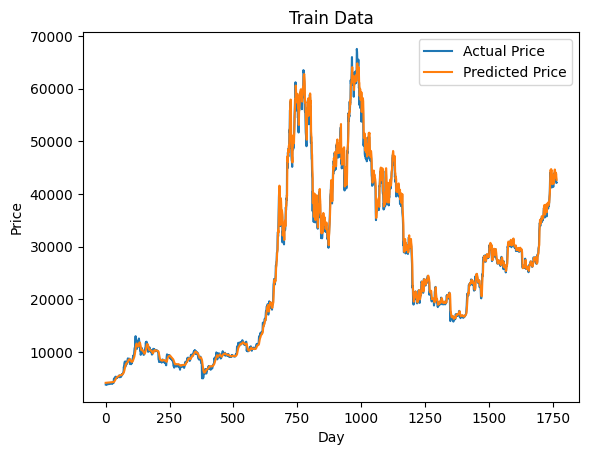

In [24]:
predict_and_plot(trainX, trainY, 'Train Data')

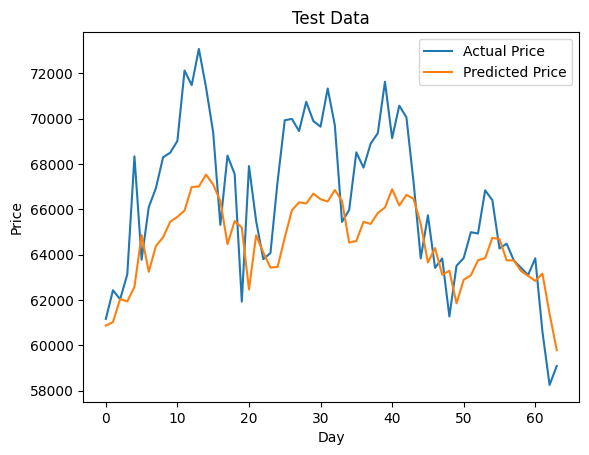

In [25]:
predict_and_plot(testX, testY, 'Test Data')

## Part I: try different n_steps

In [26]:
def train_on_different_n_steps(n_steps):
    """
    Trains the model on different sequence lengths.

    Args:
        n_steps (list): List of sequence lengths to train the model on.

    Returns:
        None
    """

    for n in n_steps:
        # Craeting data sequence with specified number of steps
        trainX, trainY = create_dataset(train_data_open, n)
        testX, testY = create_dataset(test_data_open, n)

        # Converting each numpy array to tensor
        trainX = convert_numpy_to_tensor(trainX)
        trainY = convert_numpy_to_tensor(trainY)
        testX = convert_numpy_to_tensor(testX)
        testY = convert_numpy_to_tensor(testY)

        # Instantiate model and make it ready for device used
        model = BTC_LSTM_Model(1, 50, 4, 0.2, True)
        model.to(device)

        # Create a dataset from train and test data
        train_dataset = StockDataset(trainX, trainY)
        test_dataset = StockDataset(testX, testY)

        # Create a dataloader to train model using datasets created
        train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
        test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

        print(f'Training Model with {n} number of steps for sequence prediction...')

        # Train the model
        train(log_train=False)

        print(f'\tTraining Finished')
        print()

        # Plot the predictions for train and test data
        predict_and_plot(trainX, trainY, f'Train Data for {n} number of steps')
        predict_and_plot(testX, testY, f'Test Data for {n} number of steps')

        print()

Training Model with 2 number of steps for sequence prediction...
	Training Finished



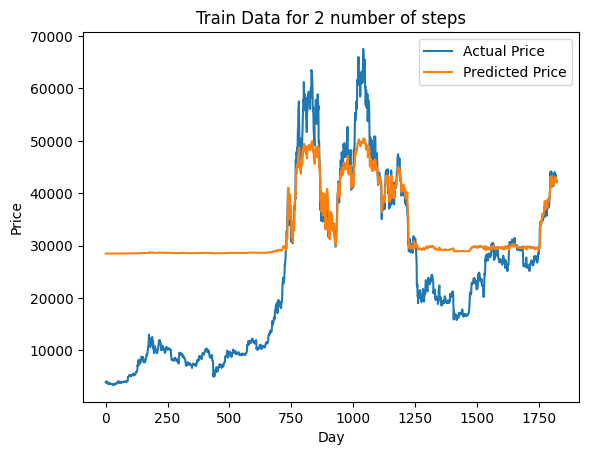

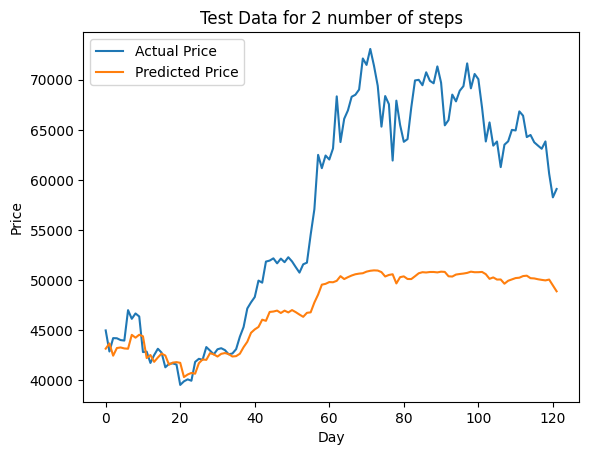


Training Model with 7 number of steps for sequence prediction...
	Training Finished



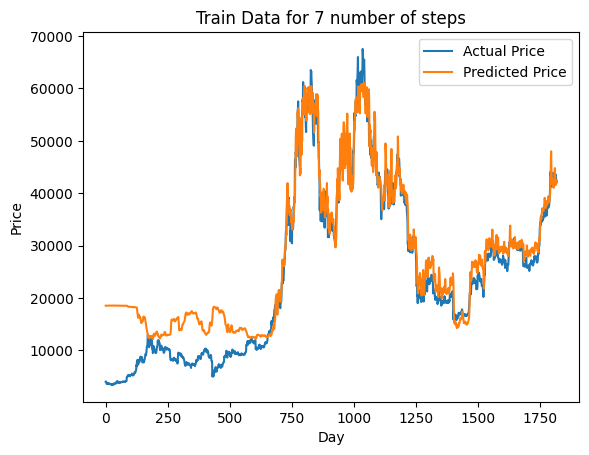

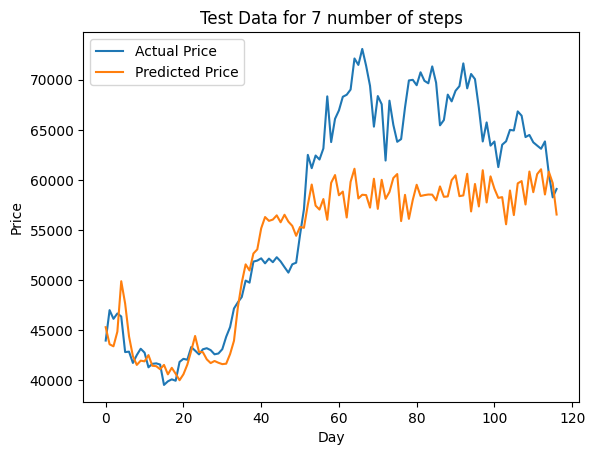


Training Model with 15 number of steps for sequence prediction...
	Training Finished



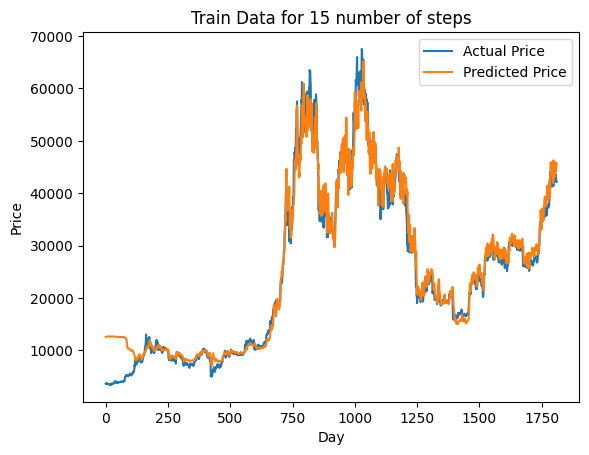

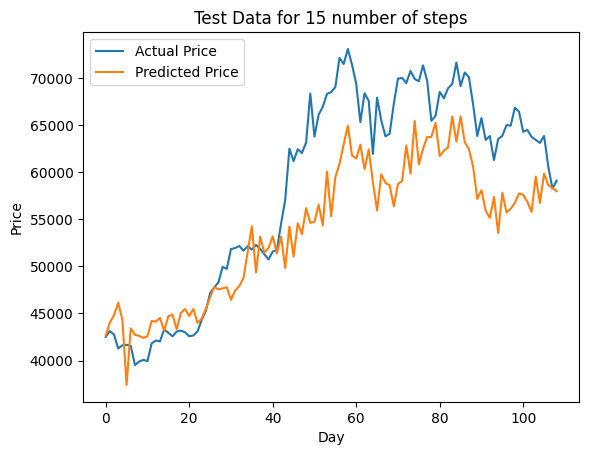


Training Model with 30 number of steps for sequence prediction...
	Training Finished



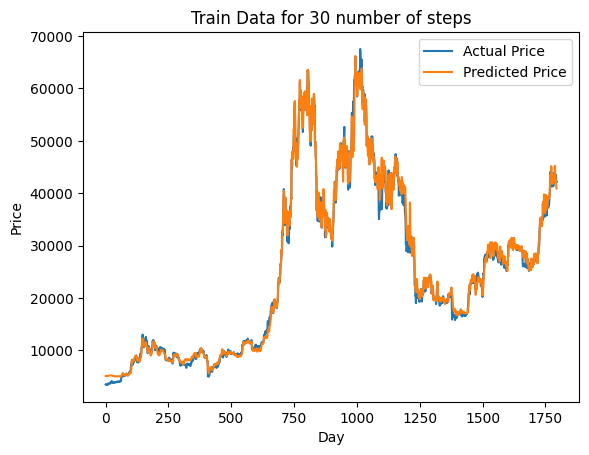

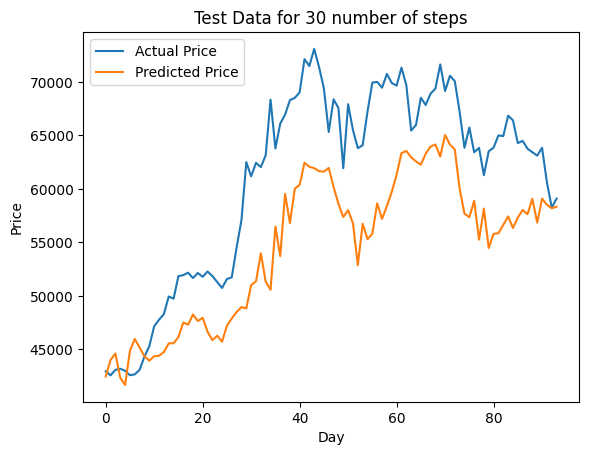


Training Model with 60 number of steps for sequence prediction...
	Training Finished



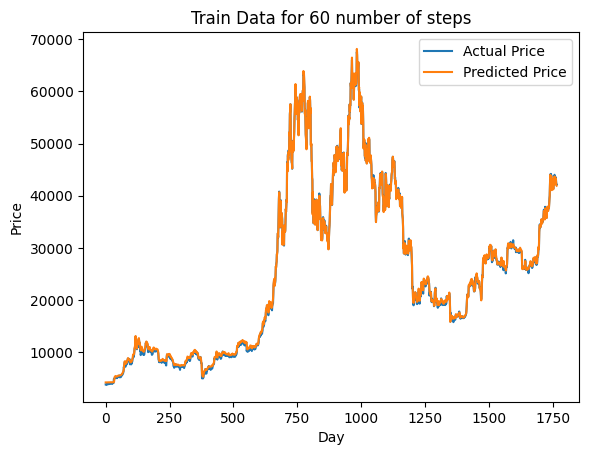

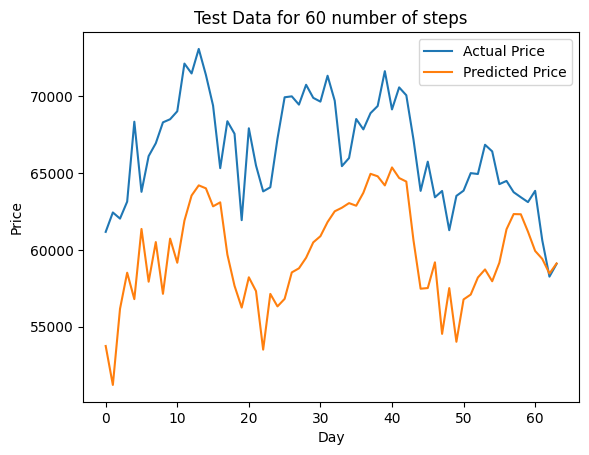


Training Model with 100 number of steps for sequence prediction...
	Training Finished



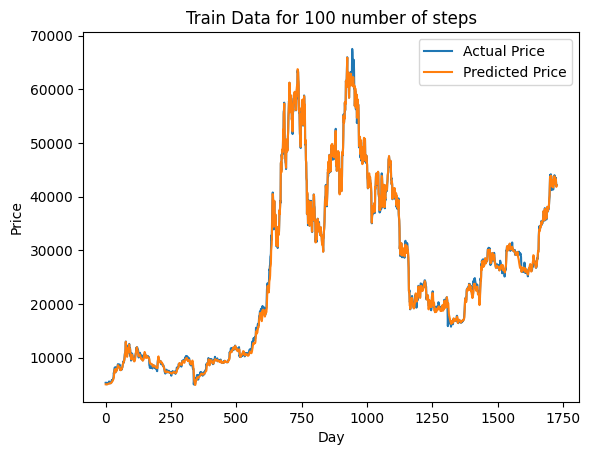

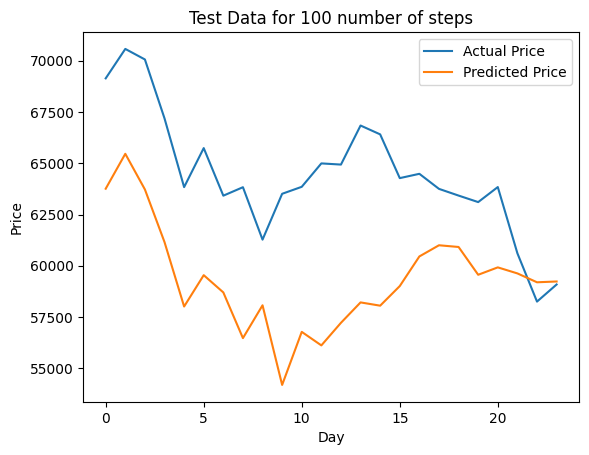

In [28]:
train_on_different_n_steps([2, 7, 15, 30, 60, 100])